In [15]:
import pandas as pd
import os, json, time, warnings, numpy as np, pandas as pd, matplotlib.pyplot as plt, time
from typing import Dict, List, Tuple, Any
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.pipeline import Pipeline
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, StratifiedKFold



from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import (RandomForestClassifier, ExtraTreesClassifier, 
                              GradientBoostingClassifier, AdaBoostClassifier)
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, roc_auc_score,
    roc_curve, confusion_matrix, ConfusionMatrixDisplay, RocCurveDisplay, PrecisionRecallDisplay
)


In [16]:
df = pd.read_csv("heart_failure_clinical_records_dataset.csv")
df.head()


,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,time,DEATH_EVENT
0,75.0,0,582,0,20,1,265000.00,1.9,130,1,0,4,1
1,55.0,0,7861,0,38,0,263358.03,1.1,136,1,0,6,1
2,65.0,0,146,0,20,0,162000.00,1.3,129,1,1,7,1
3,50.0,1,111,0,20,0,210000.00,1.9,137,1,0,7,1
4,65.0,1,160,1,20,0,327000.00,2.7,116,0,0,8,1


In [17]:
df.shape

(299, 13)

In [18]:
df.dtypes

age                         float64
anaemia                       int64
creatinine_phosphokinase      int64
diabetes                      int64
ejection_fraction             int64
high_blood_pressure           int64
platelets                   float64
serum_creatinine            float64
serum_sodium                  int64
sex                           int64
smoking                       int64
time                          int64
DEATH_EVENT                   int64
dtype: object

In [19]:
df[df.duplicated]#affiche uniquement les doublons et on voit qu'il n'y en a pas

,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,time,DEATH_EVENT


In [20]:
df.isnull().sum() #recherche les valeurs manquantes

age                         0
anaemia                     0
creatinine_phosphokinase    0
diabetes                    0
ejection_fraction           0
high_blood_pressure         0
platelets                   0
serum_creatinine            0
serum_sodium                0
sex                         0
smoking                     0
time                        0
DEATH_EVENT                 0
dtype: int64

In [21]:
y = df["DEATH_EVENT"]
X = df.drop(columns=["DEATH_EVENT"])
print("Forme :", X.shape, "| classes:", y.value_counts(normalize=True).round(3).to_dict())

Forme : (299, 12) | classes: {0: 0.679, 1: 0.321}


,dtype,n_unique,n_missing,pct_missing
age,float64,47,0,0.0
anaemia,int64,2,0,0.0
creatinine_phosphokinase,int64,208,0,0.0
diabetes,int64,2,0,0.0
ejection_fraction,int64,17,0,0.0
high_blood_pressure,int64,2,0,0.0
platelets,float64,176,0,0.0
serum_creatinine,float64,40,0,0.0
serum_sodium,int64,27,0,0.0
sex,int64,2,0,0.0


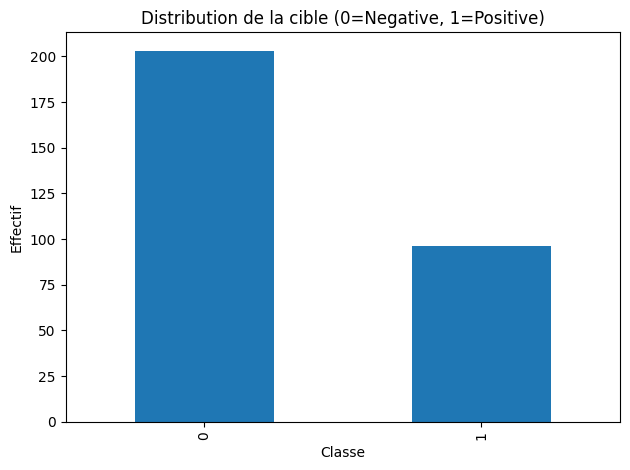

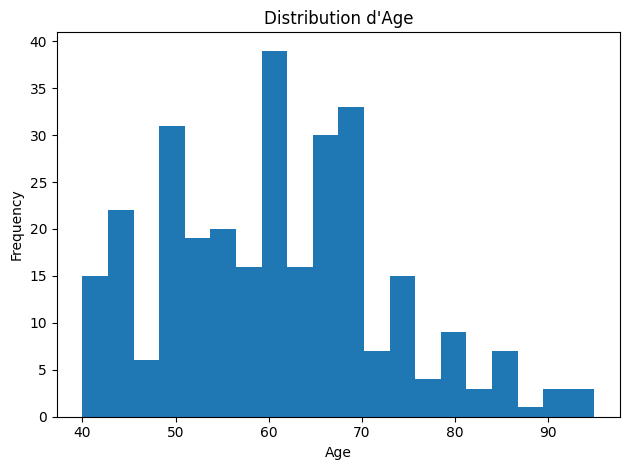

In [22]:


# récapitulatif colonnes
summary = pd.DataFrame({
    "dtype": X.dtypes.astype(str),
    "n_unique": X.nunique(),
    "n_missing": X.isna().sum(),
    "pct_missing": (X.isna().mean()*100).round(2),
})
display(summary)

# déséquilibre de la cible
ax = y.value_counts().sort_index().plot(kind="bar")
ax.set_title("Distribution de la cible (0=Negative, 1=Positive)")
ax.set_xlabel("Classe"); ax.set_ylabel("Effectif"); plt.tight_layout(); plt.show()

# distribution d'Age
ax = X["age"].plot(kind="hist", bins=20)
ax.set_title("Distribution d'Age"); ax.set_xlabel("Age"); plt.tight_layout(); plt.show()


In [23]:
from sklearn.feature_selection import mutual_info_classif # information mutuelle au lieu de khi deux


# 1. Corrélations (pour toutes les variables)
# Permet de voir l'impact linéaire (ex: serum_creatinine vs DEATH_EVENT)
correlations = df.corr()['DEATH_EVENT'].sort_values(ascending=False)
print("--- Corrélations avec DEATH_EVENT ---")
print(correlations)


# calcule des scores (plus c'est haut, plus c'est important)
importance = mutual_info_classif(X, y, random_state=42)

# Affichage propre
feature_scores = pd.Series(importance, index=X.columns).sort_values(ascending=False)
print("Importance réelle des variables :")
print(feature_scores)


--- Corrélations avec DEATH_EVENT ---
DEATH_EVENT                 1.000000
serum_creatinine            0.294278
age                         0.253729
high_blood_pressure         0.079351
anaemia                     0.066270
creatinine_phosphokinase    0.062728
diabetes                   -0.001943
sex                        -0.004316
smoking                    -0.012623
platelets                  -0.049139
serum_sodium               -0.195204
ejection_fraction          -0.268603
time                       -0.526964
Name: DEATH_EVENT, dtype: float64
Importance réelle des variables :
time                        0.240798
serum_creatinine            0.076126
ejection_fraction           0.061117
age                         0.047854
creatinine_phosphokinase    0.030779
serum_sodium                0.021283
smoking                     0.016590
high_blood_pressure         0.009862
diabetes                    0.000000
anaemia                     0.000000
platelets                   0.000000
sex   

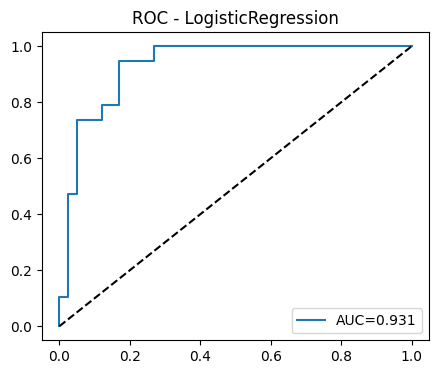

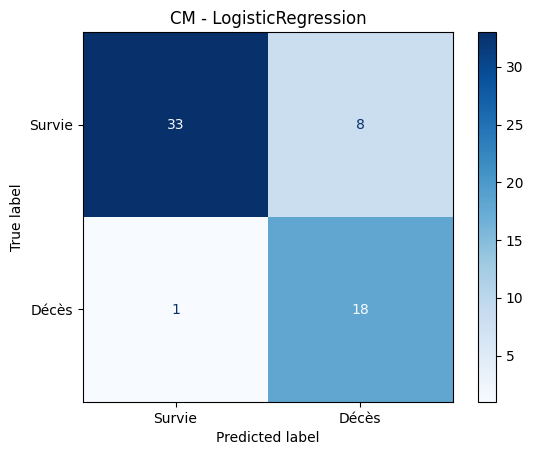

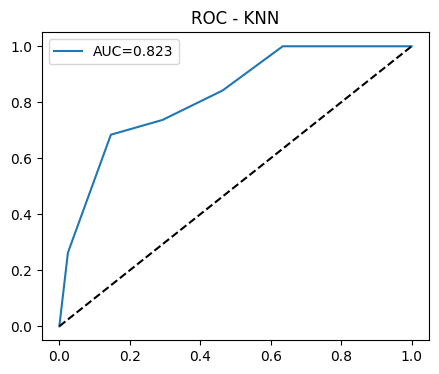

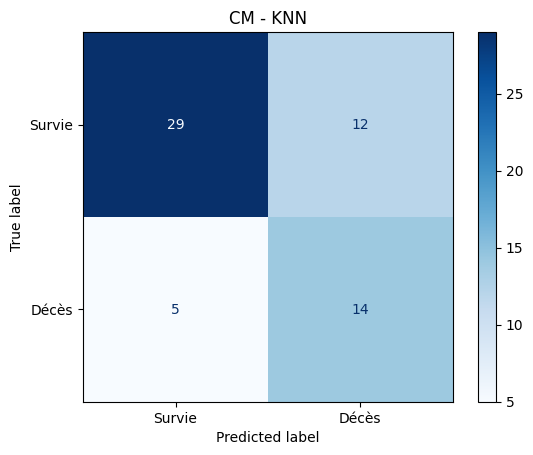

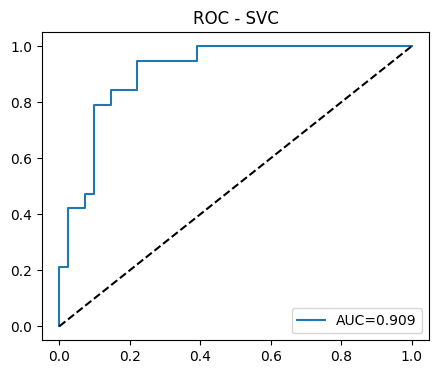

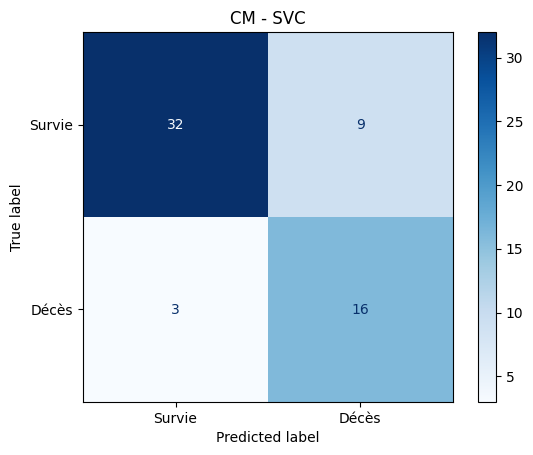

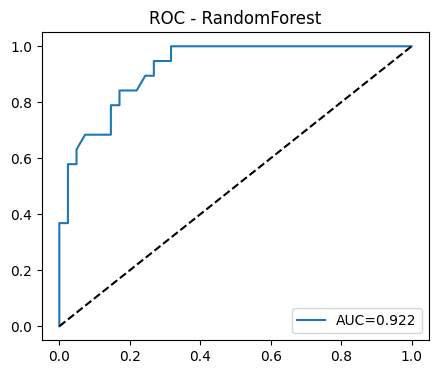

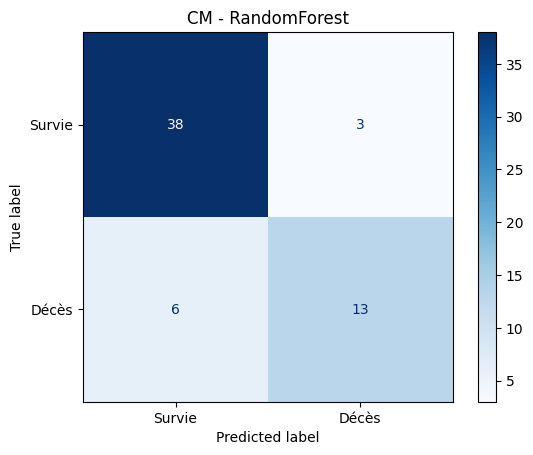

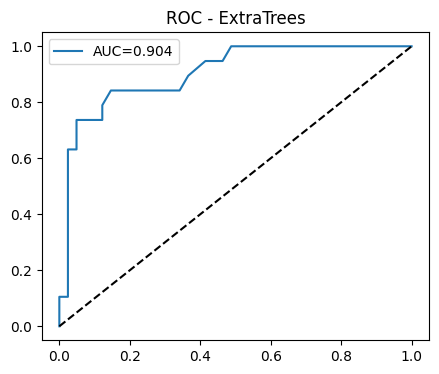

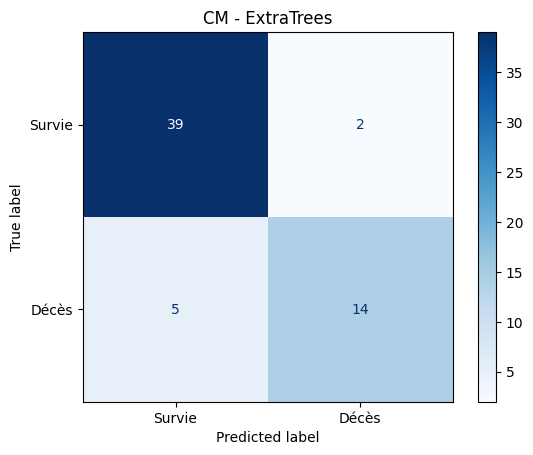

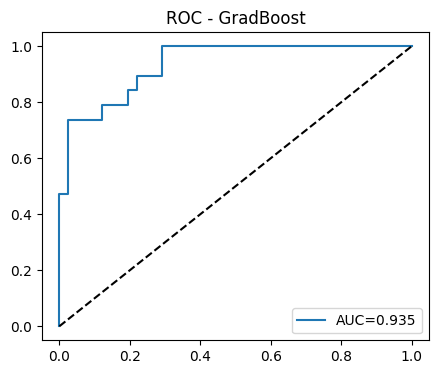

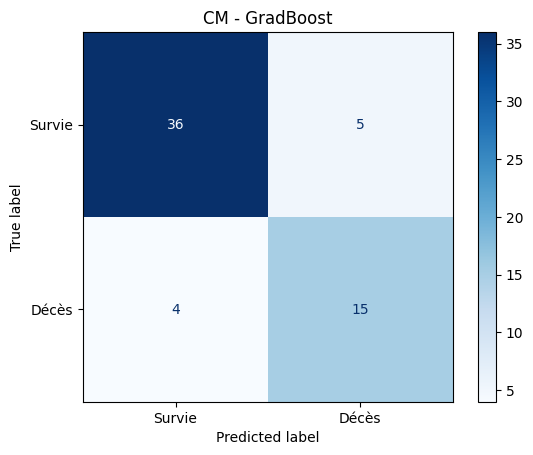

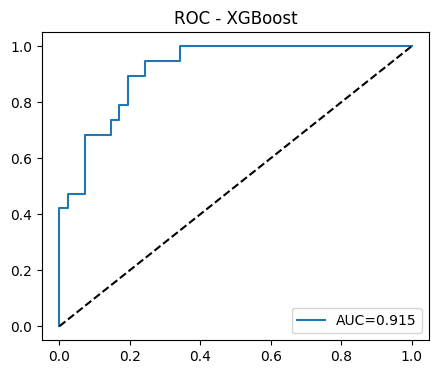

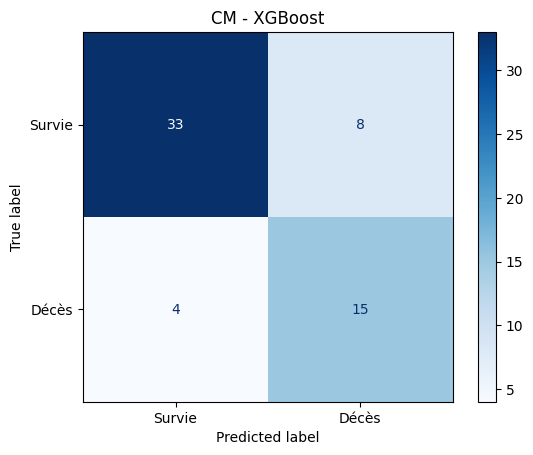

/home/niaina/venv_ml/lib/python3.13/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/home/niaina/venv_ml/lib/python3.13/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


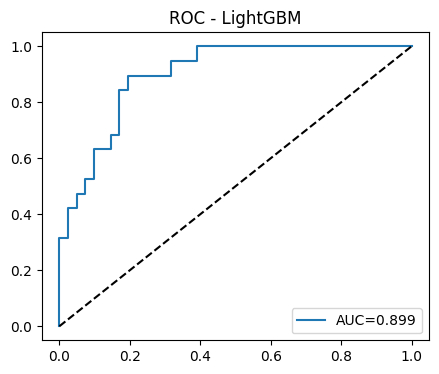

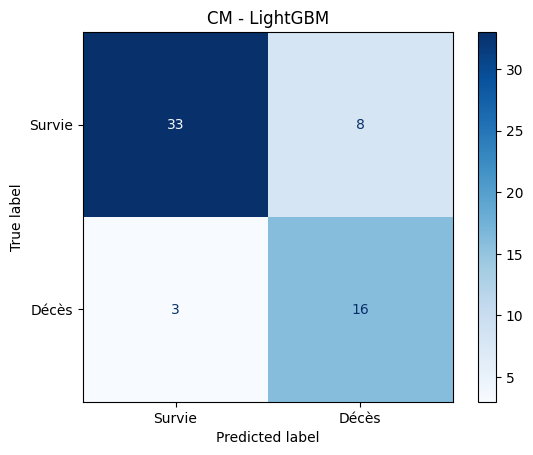


=== CLASSEMENT DES MODÈLES (AUC) ===


,accuracy,f1,recall,precision,roc_auc,model,train_time_sec
0,0.850000,0.769231,0.789474,0.750000,0.934531,GradBoost,0.325
1,0.850000,0.800000,0.947368,0.692308,0.930680,LogisticRegression,0.111
2,0.850000,0.742857,0.684211,0.812500,0.921694,RandomForest,0.337
3,0.800000,0.714286,0.789474,0.652174,0.915276,XGBoost,0.089
4,0.800000,0.727273,0.842105,0.640000,0.908858,SVC,0.036
5,0.883333,0.800000,0.736842,0.875000,0.904365,ExtraTrees,0.291
6,0.816667,0.744186,0.842105,0.666667,0.898588,LightGBM,0.049
7,0.716667,0.622222,0.736842,0.538462,0.822850,KNN,0.027



Top-3 sélectionnés pour tuning : ['GradBoost', 'LogisticRegression', 'RandomForest']


In [24]:

# --- Fonctions de Diagnostic ---

def get_scores_for_auc(pipe, X):
    if hasattr(pipe, "predict_proba"):
        return pipe.predict_proba(X)[:, 1]
    elif hasattr(pipe, "decision_function"):
        return pipe.decision_function(X)
    return None

def compute_metrics_safe(y_true, y_pred, y_score):
    return {
        "accuracy": accuracy_score(y_true, y_pred),
        "f1": f1_score(y_true, y_pred, zero_division=0),
        "recall": recall_score(y_true, y_pred, zero_division=0),
        "precision": precision_score(y_true, y_pred, zero_division=0),
        "roc_auc": roc_auc_score(y_true, y_score) if y_score is not None else 0
    }

def rank_df(df):
    return df.sort_values(by="roc_auc", ascending=False).reset_index(drop=True)

# ---  Préparation des données ---

num_features = ['age', 'creatinine_phosphokinase', 'ejection_fraction', 
                'platelets', 'serum_creatinine', 'serum_sodium', 'time']
cat_features = ['anaemia', 'diabetes', 'high_blood_pressure', 'sex', 'smoking']# valeur binaire
target = 'DEATH_EVENT'


df_clean = df.drop_duplicates().reset_index(drop=True) # il n' y a pas de doublons mais on va le faire quand meme
X = df_clean.drop(columns=[target])
y = df_clean[target]

# --- 4. Pipelines de Prétraitement ---

preprocessor = ColumnTransformer(transformers=[
    ("num", Pipeline(steps=[
        ("imputer", SimpleImputer(strategy="median")),
        ("scaler", StandardScaler())
    ]), num_features),
    ("cat", Pipeline(steps=[
        ("imputer", SimpleImputer(strategy="most_frequent")),
        ("ohe", OneHotEncoder(handle_unknown="ignore"))
    ]), cat_features)
])

X_temp, X_test, y_temp, y_test = train_test_split(
    X, y, test_size=0.20, random_state=42, stratify=y
)
X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp, test_size=0.25, random_state=42, stratify=y_temp
)

scale_pos = (y_train == 0).sum() / (y_train == 1).sum()

# --- Définition des 8 Modèles ---

models_dict = {
    "LogisticRegression": LogisticRegression(class_weight="balanced", max_iter=2000),
    "KNN": KNeighborsClassifier(n_neighbors=5),
    "SVC": SVC(probability=True, class_weight="balanced", random_state=42),
    "RandomForest": RandomForestClassifier(class_weight="balanced", random_state=42),
    "ExtraTrees": ExtraTreesClassifier(class_weight="balanced", random_state=42),
    "GradBoost": GradientBoostingClassifier(random_state=42),
    "XGBoost": XGBClassifier(scale_pos_weight=scale_pos, eval_metric="logloss", random_state=42),
    "LightGBM": LGBMClassifier(scale_pos_weight=scale_pos, random_state=42, verbose=-1)
}

# --- Évaluation Baseline ---

os.makedirs("figs_baseline", exist_ok=True)
records = []

for name, model in models_dict.items():
    t0 = time.time()
    steps = [("pre", preprocessor)]
    if name in ["KNN", "GradBoost"]:
        steps.append(("smote", SMOTE(random_state=42)))
    steps.append(("clf", model))
    
    pipe = ImbPipeline(steps=steps)
    pipe.fit(X_train, y_train)
    t1 = time.time() - t0

    y_pred = pipe.predict(X_val)
    y_score = get_scores_for_auc(pipe, X_val)
    
    m = compute_metrics_safe(y_val, y_pred, y_score)
    m.update({"model": name, "train_time_sec": round(t1, 3)})
    records.append(m)

    # Sauvegardes visuelles
    if y_score is not None:
        fpr, tpr, _ = roc_curve(y_val, y_score)
        plt.figure(figsize=(5,4))
        plt.plot(fpr, tpr, label=f"AUC={m['roc_auc']:.3f}")
        plt.plot([0,1],[0,1], "k--")
        plt.title(f"ROC - {name}")
        plt.legend()
        plt.savefig(f"figs_baseline/roc_{name}.png")
        plt.show()

    cm = confusion_matrix(y_val, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Survie", "Décès"])
    disp.plot(cmap='Blues')
    plt.title(f"CM - {name}")
    plt.savefig(f"figs_baseline/cm_{name}.png")
    plt.show()

#Synthèse et préparation du Top 3 

baseline_results = rank_df(pd.DataFrame(records))
print("\n=== CLASSEMENT DES MODÈLES (AUC) ===")
display(baseline_results)

top3_names = baseline_results.head(3)["model"].tolist()
print("\nTop-3 sélectionnés pour tuning :", top3_names)

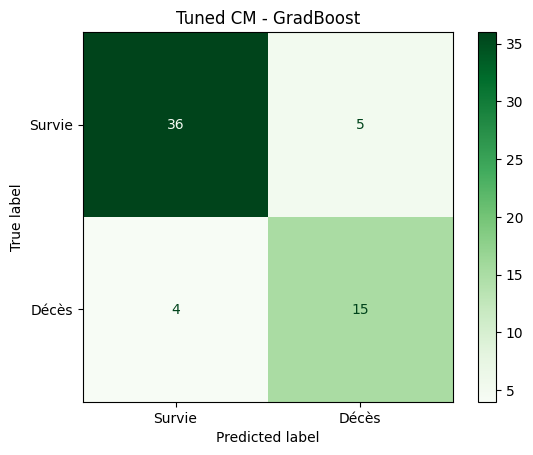

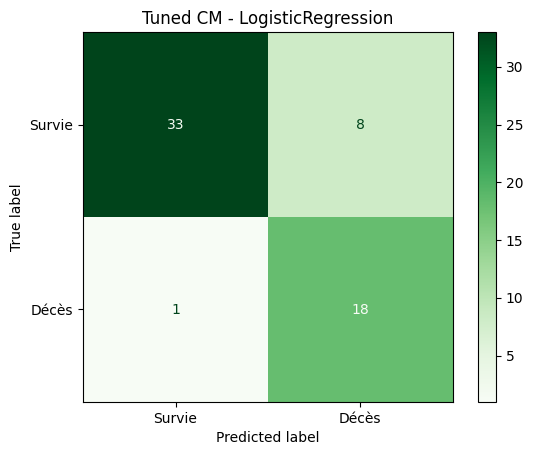

/home/niaina/venv_ml/lib/python3.13/site-packages/sklearn/model_selection/_search.py:317: UserWarning: The total space of parameters 12 is smaller than n_iter=20. Running 12 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


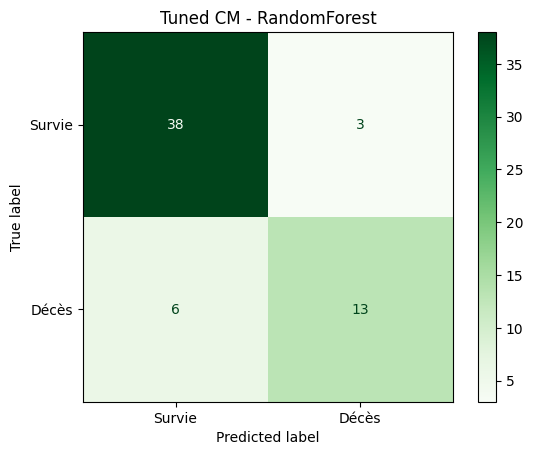

,accuracy,f1,recall,precision,roc_auc,model,best_params,cv_auc,time
0,0.85,0.800000,0.947368,0.692308,0.942234,LogisticRegression,"{""clf__C"": 0.01291549665014884, ""clf__penalty""...",0.856899,5.96
1,0.85,0.769231,0.789474,0.750000,0.934531,GradBoost,{},NaN,0.00
2,0.85,0.742857,0.684211,0.812500,0.920411,RandomForest,"{""clf__n_estimators"": 200, ""clf__min_samples_s...",0.910287,21.98


In [25]:


#je recrèe les pipelines complets pour le Tuning
top3_pipelines = {}
for name in top3_names:
    model = models_dict[name]
    steps = [("pre", preprocessor)]
    if name in ["KNN", "GradBoost"]:
        steps.append(("smote", SMOTE(random_state=42)))
    steps.append(("clf", model))
    top3_pipelines[name] = ImbPipeline(steps=steps)

# --- 8. Fonctions de Tuning ---

def search_space(model_name: str):
    if model_name == "LogisticRegression":
        return {"clf__C": np.logspace(-3, 2, 10), "clf__penalty": ["l2"], "clf__solver": ["lbfgs"]}
    if model_name == "KNN":
        return {"clf__n_neighbors": list(range(3, 31, 2)), "clf__weights": ["uniform", "distance"], "clf__p": [1, 2]}
    if model_name == "SVC":
        return {"clf__C": np.logspace(-2, 2, 8), "clf__gamma": ["scale", "auto"], "clf__kernel": ["rbf"]}
    if model_name == "RandomForest":
        return {"clf__n_estimators": [200, 400], "clf__max_depth": [None, 6, 10], "clf__min_samples_split": [2, 5]}
    if model_name == "XGBoost":
        return {"clf__n_estimators": [300, 500], "clf__max_depth": [3, 4, 5], "clf__learning_rate": [0.03, 0.1]}
    if model_name == "LightGBM":
        return {"clf__n_estimators": [300, 500], "clf__learning_rate": [0.03, 0.1], "clf__num_leaves": [15, 31]}
    return {}

#optimisation
def optimize_models(pipes: Dict[str, ImbPipeline], n_iter=20, cv_splits=5, seed=42):
    os.makedirs("figs_tuned", exist_ok=True)
    tuned_records, tuned_pipes = [], {}
    cv = StratifiedKFold(n_splits=cv_splits, shuffle=True, random_state=seed)

    for name, pipe in pipes.items():
        space = search_space(name)
        if not space:
            pipe.fit(X_train, y_train)
            best = pipe
            t1, cv_score, params = 0, None, {}
        else:
            if name == "LogisticRegression":
                search = GridSearchCV(pipe, param_grid=space, scoring="roc_auc", cv=cv, n_jobs=-1)
            else:
                search = RandomizedSearchCV(pipe, param_distributions=space, n_iter=n_iter, 
                                             scoring="roc_auc", cv=cv, n_jobs=-1, random_state=seed)
            t0 = time.time()
            search.fit(X_train, y_train)
            t1 = time.time() - t0
            best = search.best_estimator_
            cv_score = search.best_score_
            params = search.best_params_

        y_pred = best.predict(X_val)
        y_score = get_scores_for_auc(best, X_val)
        m = compute_metrics_safe(y_val, y_pred, y_score)
        m.update({"model": name, "best_params": json.dumps(params), "cv_auc": cv_score, "time": round(t1, 2)})
        
        tuned_pipes[name] = best
        tuned_records.append(m)

        # Affichage des résultats tunés
        cm = confusion_matrix(y_val, y_pred)
        ConfusionMatrixDisplay(cm, display_labels=["Survie", "Décès"]).plot(cmap='Greens')
        plt.title(f"Tuned CM - {name}")
        plt.show()

    return rank_df(pd.DataFrame(tuned_records)), tuned_pipes

# --- Exécution finale ---
tuned_results, final_pipes = optimize_models(top3_pipelines)
display(tuned_results)


Entraînement final sur Train + Val pour : ['GradBoost', 'LogisticRegression', 'RandomForest']


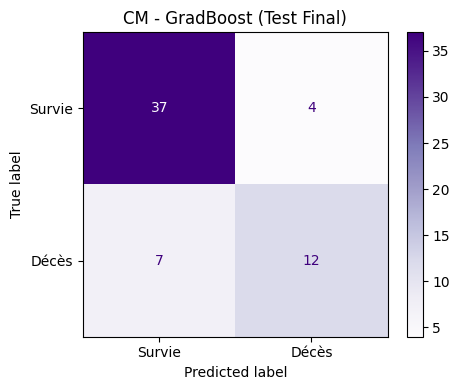

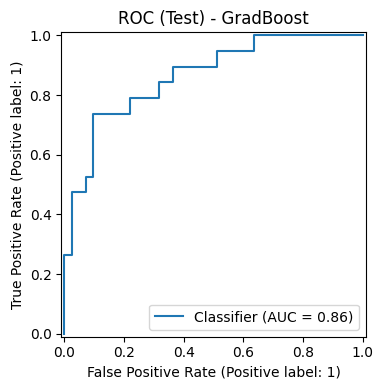

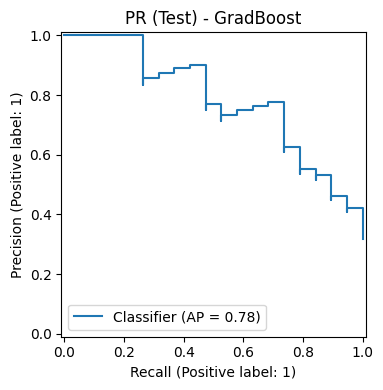

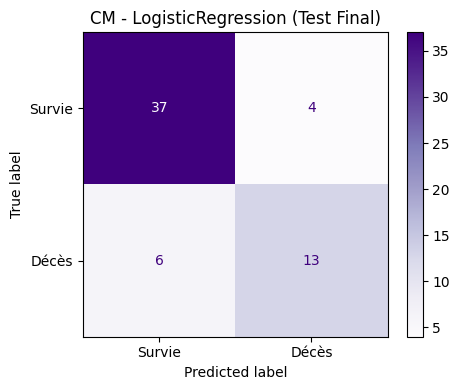

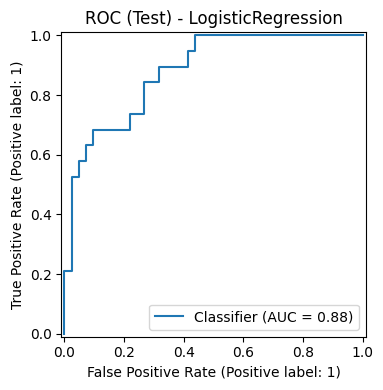

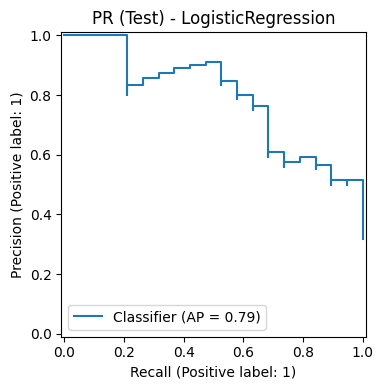

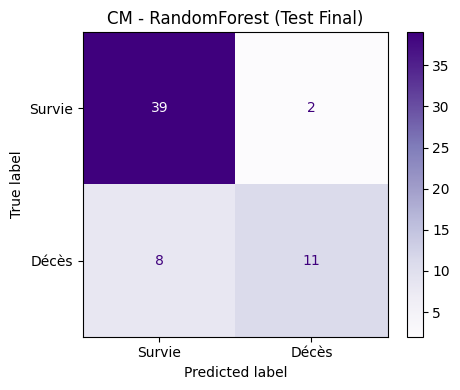

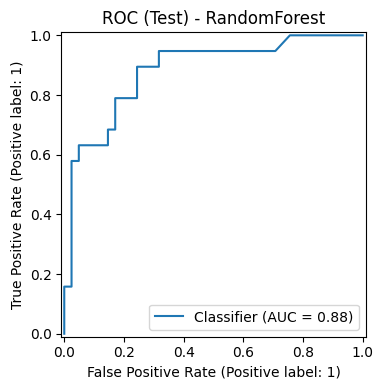

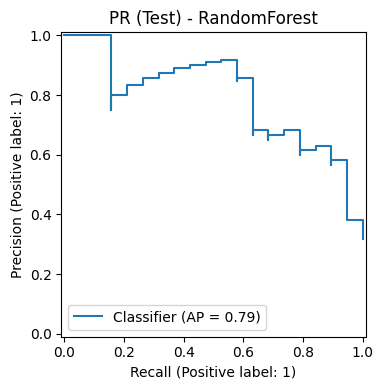


=== RÉSULTATS FINAUX SUR LE TEST SET ===


,accuracy,f1,recall,precision,roc_auc,model
0,0.833333,0.687500,0.578947,0.846154,0.880616,RandomForest
1,0.833333,0.722222,0.684211,0.764706,0.879332,LogisticRegression
2,0.816667,0.685714,0.631579,0.750000,0.862644,GradBoost



Fichiers sauvegardés : ['baseline_validation_results.csv', 'tuned_validation_results.csv', 'final_test_results.csv']


In [26]:
# --- 10. Évaluation Finale (Fusion Train+Val -> Test) ---
import os
from sklearn.metrics import RocCurveDisplay, PrecisionRecallDisplay

# Création du dossier pour les résultats finaux
os.makedirs("figs_final", exist_ok=True)

# Sélection automatique des meilleurs modèles à tester
# On priorise les modèles optimisés (tuned), sinon on prend le top3
candidates = final_pipes if 'final_pipes' in locals() and len(final_pipes) > 0 else top3_pipelines

best_final = {}
print(f"Entraînement final sur Train + Val pour : {list(candidates.keys())}")

for name, pipe in candidates.items():
    # RE-ENTRAÎNEMENT : On fusionne Train et Val pour plus de puissance
    X_full_train = pd.concat([X_train, X_val])
    y_full_train = pd.concat([y_train, y_val])
    
    pipe.fit(X_full_train, y_full_train)
    best_final[name] = pipe

rows = []
for name, pipe in best_final.items():
    # Prédictions sur le set de TEST (les données jamais vues)
    y_pred = pipe.predict(X_test)
    y_score = get_scores_for_auc(pipe, X_test)
    
    # Calcul des métriques
    m = compute_metrics_safe(y_test, y_pred, y_score)
    m["model"] = name
    rows.append(m)

    # --- 1. Matrice de Confusion ---
    cm = confusion_matrix(y_test, y_pred)
    fig, ax = plt.subplots(figsize=(5, 4))
    ConfusionMatrixDisplay(cm, display_labels=["Survie", "Décès"]).plot(values_format="d", cmap='Purples', ax=ax)
    plt.title(f"CM - {name} (Test Final)")
    plt.tight_layout()
    plt.savefig(f"figs_final/cm_test_{name}.png", dpi=150)
    plt.show()

    # --- 2. Courbe ROC ---
    if y_score is not None and len(np.unique(y_test)) == 2:
        plt.figure(figsize=(5, 4))
        RocCurveDisplay.from_predictions(y_test, y_score, ax=plt.gca())
        plt.title(f"ROC (Test) - {name}")
        plt.tight_layout()
        plt.savefig(f"figs_final/roc_test_{name}.png", dpi=150)
        plt.show()

        # --- 3. Courbe Precision-Recall (Très utile pour le déséquilibre) ---
        plt.figure(figsize=(5, 4))
        PrecisionRecallDisplay.from_predictions(y_test, y_score, ax=plt.gca())
        plt.title(f"PR (Test) - {name}")
        plt.tight_layout()
        plt.savefig(f"figs_final/pr_test_{name}.png", dpi=150)
        plt.show()

# --- 11. Synthèse et Exports ---

final_results = rank_df(pd.DataFrame(rows))
print("\n=== RÉSULTATS FINAUX SUR LE TEST SET ===")
display(final_results)

# Exportations CSV
baseline_results.to_csv("baseline_validation_results.csv", index=False)
if 'tuned_results' in locals():
    tuned_results.to_csv("tuned_validation_results.csv", index=False)
final_results.to_csv("final_test_results.csv", index=False)

print("\nFichiers sauvegardés :", ["baseline_validation_results.csv", "tuned_validation_results.csv", "final_test_results.csv"])